In [404]:
import torchvision.models as models
import torch
import numpy as np
import torch.nn as nn
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd
%matplotlib inline

# Loss functions

In [407]:
vgg = models.vgg16(pretrained=True)

In [408]:
list(vgg.features)[:12]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace)]

In [409]:
from collections import OrderedDict
layers = []
for i, layer in enumerate(list(vgg.features)[:12]):
    layer_name = "layer_"+str(i)
    if type(layer) is torch.nn.modules.pooling.MaxPool2d:
        layers.append((layer_name, nn.AvgPool2d((2, 2))))
    else:
        layers.append((layer_name, layer))
        
vgg_avg_pooling = nn.Sequential(OrderedDict(layers))

In [410]:
mse = nn.MSELoss()
def content_loss(generated_image, content_image):
    pred = vgg_avg_pooling.forward(generated_image.unsqueeze(0))
    t = vgg_avg_pooling.forward(content_image.unsqueeze(0))
    t = Variable(t.data)
    return mse(pred, t)

### Using the content_loss function, recreate our image from random noise

In [411]:
original_image = U.folder[0][0]
target = Variable(original_image)

noise_tensor = torch.rand(3,224, 224) - 0.5
noise = Variable(noise_tensor, requires_grad= True)

#### Noise starts as

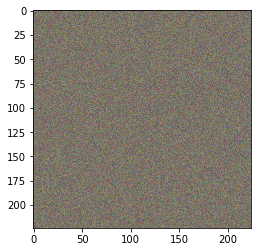

In [356]:
U.imshow(noise_tensor)

#### Original image

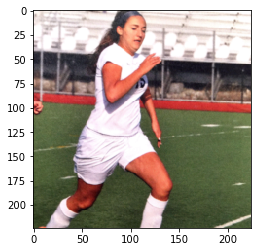

In [357]:
U.imshow(original_image)

# Minimize noise based on vgg output

In [412]:
from scipy.optimize import fmin_l_bfgs_b 

In [413]:
def loss_fn(gen_img):
    prediction = Variable(torch.Tensor(gen_img.reshape(target.size())), requires_grad= True)                                                         
    loss_amt = content_loss(prediction, target)                                                                                                
    loss_amt.backward()                                                                                                                        
    gradients = prediction.grad.data.numpy().flatten().astype(np.float64)                                                                      
    loss = loss_amt.data.numpy().astype(np.float64), gradients  
    return loss, gradients

Epoch 0 Loss: (array([ 1.06345844]), array([  9.28482223e-07,  -9.60123907e-06,  -8.88431350e-06, ...,
         4.65497578e-06,  -7.38289464e-06,  -2.09807581e-06]))
Epoch 1 Loss: (array([ 0.59596872]), array([ -3.64211860e-06,   1.50738902e-06,  -3.49613174e-07, ...,
         3.33457274e-06,   1.97136546e-06,   1.01127955e-06]))
Epoch 2 Loss: (array([ 0.42392766]), array([ -1.52013399e-06,  -5.24384222e-06,  -9.72807175e-06, ...,
         2.92642176e-06,  -1.35741118e-07,   8.54062876e-07]))
Epoch 3 Loss: (array([ 0.33542427]), array([ -1.75353239e-06,   2.86047850e-07,  -2.05410811e-06, ...,
         4.93184962e-06,   2.84652424e-06,   2.05686683e-06]))
Epoch 4 Loss: (array([ 0.28374177]), array([ -2.54495944e-06,  -1.25709585e-06,  -2.49267578e-06, ...,
         2.06867480e-06,   2.94241545e-06,   1.99394117e-06]))
Epoch 5 Loss: (array([ 0.2441126]), array([ -1.49155790e-06,  -1.21629057e-06,  -3.35545928e-06, ...,
         2.02555702e-06,   8.57697501e-07,   9.21151582e-07]))
Epoch

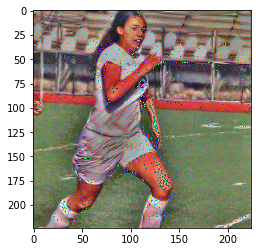

In [416]:
gen_image = noise.data.numpy().flatten()
for i in range(10):
    generated_image, min_val, y = fmin_l_bfgs_b(loss_fn, gen_image, maxfun=10)
    print("Epoch "+str(i) + " Loss: " +str(min_val))
    gen_image = generated_image